In [ ]:
#These codes are made for calculating the asymmetric parameter eta.

#Authors: 
#Zehao Zhong
#Gang Zhao
#Hans-Walter Rix

#This example is used to calculate the asymmetry parameter, and could reproduced the results in our article (Fig. 2).


#You may need these reference:
#Our paper (in preparation)
#(Data and tables from SAMI survey Dr3):
#Croom, S. et al. 2021, MNRAS, 505, 991–1016 (SAMI survey Dr3)
#Owers, M. et al. 2017, MNRAS, 468, 1824–1849 (table InputCatClustersDR3)
#D’Eugenio, F. et al. 2021, MNRAS, 504, 5098–5130 (table MGEPhotomUnregDR3)
#Cortese, L. et al. 2016, MNRAS, 463, 170–184 (table VisualMorphologyDR3)
#van de Sande, J. et al. 2017, APJ, 835, 104 (stellar kinematics)
#Bryant, J. et al. 2015, MNRAS, 447, 2857–2879 (table InputCatGAMADR3)


#The details of these codes are showed in the 'Methods' section of our paper.

#If you would like to replot the figures in our article, please download the 
#corresponding SAMI data and tables, and then run the program. The method 
#of calculating eta of TNG DATA is similar, and the code is not repeated here.

#Or if you would like to calculate the asymmetric parameter eta of your 
#own IFU data. Please look at the core function 'calind2inv3' and 'calchinreMCv14',
#you can also refer to function 'spldgnfdr3v9'

#Please note that modify the corresponding path to your own path when running the program.

In [1]:
#These are the python libraries pre-needed.
import numpy as np
from astropy.io import fits
import os
import pandas as pd
import time
from multiprocessing import Pool
from functools import partial
import matplotlib.pyplot as plt
from scipy.integrate import quad

In [2]:
import matplotlib
matplotlib.rcParams['font.size']=16
matplotlib.rcParams['legend.fontsize']=15
matplotlib.rcParams['xtick.labelsize']=20
matplotlib.rcParams['ytick.labelsize']=20
matplotlib.rcParams['axes.labelsize']=21
matplotlib.rcParams['axes.titlesize']=21

In [3]:
def rms_coor_tran4(rms,erms,vsn,theta,tsn=10,X=0,Y=0): #'theta' could be 'theta' from 'find_galaxy' of mge.
    #Get coordinates non NaN.
    rms_nan=np.isnan(rms)
    erms_nan=np.isnan(erms)
    vsnltsn=np.flatnonzero(vsn>=tsn)
    indrmsOK=np.flatnonzero(rms>erms)
    ind = np.intersect1d(np.flatnonzero(rms_nan== 0),np.flatnonzero(erms_nan== 0))
    ind=np.intersect1d(ind,vsnltsn)
    ind=np.intersect1d(ind,indrmsOK)
    s=rms.shape
    y0,x0=np.unravel_index(ind, s) #Note that np.unravel_index results in the reverse (y0,x0).
    x1=x0-24.5-X #The center coordinate is (25.5,25.5), but since it is from 0 to 49, it needs to subtract 24.5.
    y1=y0-24.5-Y
    theta1=theta/180*np.pi
    xbin=x1*np.cos(theta1)+(-y1)*np.sin(theta1)
    ybin=x1*np.sin(theta1)+y1*np.cos(theta1)
    return xbin,ybin,ind,x1,y1 #return coordinates
def calind2inv3(x2,y2,r_e,eps_e=0,pixsize_v=0.5):
    a=r_e/np.sqrt((1-eps_e))
    b=r_e*np.sqrt((1-eps_e))
    ind2=np.flatnonzero(((x2*pixsize_v/a)**2+(y2*pixsize_v/b)**2)<=1)
    indcoorsym0=-1*np.ones_like(ind2)
    ind2inv=np.zeros_like(ind2)
    for i in range(len(ind2)):
        coorsym=(-x2[ind2][i]==x2[ind2])*(-y2[ind2][i]==y2[ind2])
        indcoorsym0[i]=np.sum(coorsym)
        if indcoorsym0[i]==1:
            ind2inv[i]=ind2[np.flatnonzero(coorsym==1)]
    indcoorsym=np.flatnonzero(indcoorsym0==1)
    ind2=ind2[indcoorsym]
    ind2inv=ind2inv[indcoorsym]
    return ind2,ind2inv,indcoorsym0
#The maxchi2pc parameter controls the percentage of spaxels required.
def calchinreMCv14(x2,y2,r_e,rms2,erms2,c_fluxsumflat,c_fluxsumflaterr,eps_e=0,pixsize_v=0.5,maxchi2pc=90):#这里的r_e是去掉1.35的,计算re内的chi2
    ind2,ind2inv,indcoorsym=calind2inv3(x2,y2,r_e,eps_e=eps_e,pixsize_v=pixsize_v)
    max2ne=np.abs(rms2[ind2]**2-rms2[ind2inv]**2)-2*rms2[ind2]*erms2[ind2]-2*rms2[ind2inv]*erms2[ind2inv]
    chi2ne=(2*(max2ne>0)*max2ne/(rms2[ind2]**2+rms2[ind2inv]**2))
    chi2=2*np.abs(rms2[ind2]**2-rms2[ind2inv]**2)/(rms2[ind2]**2+rms2[ind2inv]**2)
    maxchi2=np.percentile(chi2,maxchi2pc)
    indchi2=np.flatnonzero(chi2<=maxchi2)
    chi2sum=np.sum((chi2*c_fluxsumflat[ind2])[indchi2])/(np.sum((c_fluxsumflat[ind2])[indchi2]))#其实chi2没变,就是chi2sum变了而已
    chi2nesum=np.sum((chi2ne*c_fluxsumflat[ind2])[indchi2])/(np.sum((c_fluxsumflat[ind2])[indchi2]))
    return ind2,ind2inv,indchi2,chi2,chi2sum,chi2nesum

In [4]:
def spldgnfv9(galname,file1vel,file1sig,pamge,epsmge_re,remge,mstar2,pixsize_v=0.5,tsn=0,maxchi2pc=90,cmap='sauron'):
    hdu1vel = fits.open(file1vel)
    hdu1sig = fits.open(file1sig)
    vel1 = hdu1vel[0].data
    sig1 = hdu1sig[0].data
    evel1=hdu1vel[1].data
    esig1=hdu1sig[1].data
    sn1=hdu1vel[4].data
    rms1=np.sqrt(vel1**2+sig1**2)
    erms1=np.sqrt((evel1*vel1)**2+(esig1*sig1)**2)/rms1
    x2,y2,ind,x1,y1=rms_coor_tran4(rms1,erms1,sn1,270-pamge,tsn=tsn)#The unit is pixel. And theta=270-pamge.
    #Here x1,y1 are corresponding x2,y2 before rotation.
    sn2=sn1.flatten()[ind]
    vel2=vel1.flatten()[ind]
    evel2=evel1.flatten()[ind]
    sig2=sig1.flatten()[ind]
    esig2=esig1.flatten()[ind]
    #Flux
    c_fluxsum=hdu1vel[2].data
    c_fluxsumerr=hdu1vel[3].data
    c_fluxsumflat=c_fluxsum.flatten()
    c_fluxsumflaterr=c_fluxsumerr.flatten()
    ind2,ind2inv,indcoorsym=calind2inv3(x2,y2,remge,eps_e=epsmge_re,pixsize_v=pixsize_v)
    #The total number of spaxels within the effective radius
    rms1_one=np.ones_like(rms1)
    x2_one,y2_one,ind_one,x1_one,y1_one=rms_coor_tran4(2*rms1_one,rms1_one,rms1_one,270-pamge,tsn=tsn)
    ind2_one,ind2inv_one,indcoorsym_one=calind2inv3(x2_one,y2_one,remge,eps_e=epsmge_re,pixsize_v=pixsize_v)
    #Subtract residual velocity
    mv0 = np.mean(vel2[ind2])
    vel2 = vel2 - mv0
    rms2=np.sqrt(vel2**2+sig2**2)
    erms2=np.sqrt((evel2*vel2)**2+(esig2*sig2)**2)/rms2
    if len(ind2)==0:
        chi2sum,chi2nesum=np.array([-1]),np.array([-1])
        print('finish'+str(galname)+',empty')
    else: 
        ind2,ind2inv,indchi2,chi2,chi2sum,chi2nesum=calchinreMCv14(x2,y2,remge,rms2,erms2,c_fluxsumflat[ind],c_fluxsumflaterr[ind],eps_e=epsmge_re,pixsize_v=pixsize_v,maxchi2pc=maxchi2pc)
        print('finish'+str(galname))
    return x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum
def spldgnfdr3v9(galname,pathfile,tsn=0,maxchi2pc=90,momtn=2,plots=0,cmap='sauron'):
    if galname<10e8:
        ggroup=1
    else:
        ggroup=0
    #ggroup=1 means gamagroup,=0 means cluster regions.
    #Should change the path to your own path.
    os.chdir(pathfile+'/samiserdr3/tables')
    file1=pathfile+'/samiserdr3/tables/others/sami_dr3_MGEPhotomUnregDR3.csv'
    dr2tsk=pd.read_csv(file1) #table for sample and kinematics
    indamet=np.flatnonzero(dr2tsk.catid.values==galname)
    pixsize_v=0.5#arcsec/pixel
    if len(indamet)>1:
        for i in range(len(indamet)):
            if dr2tsk.photometry[indamet[i]]=="VST":
                pamge=dr2tsk.pamge[indamet[i]]
                epsmge_re=dr2tsk.epsmge_re[indamet[i]]
                remge=dr2tsk.remge[indamet[i]]
    elif len(indamet)==1:
        pamge=dr2tsk.pamge[indamet[0]]
        epsmge_re=dr2tsk.epsmge_re[indamet[0]]
        remge=dr2tsk.remge[indamet[0]]
    file4=pathfile+'/samiserdr3/tables/others/sami_dr3_InputCatGAMADR3.csv'
    dr2tsk4=pd.read_csv(file4)
    file5=pathfile+'/samiserdr3/tables/others/Sami_dr3_InputCatClustersDR3.csv'
    dr2tsk5=pd.read_csv(file5)
    if galname<1e8:
        indamet4=np.flatnonzero(dr2tsk4.catid.values==galname)
        mstar2=dr2tsk4.mstar[indamet4[0]]
    else:
        indamet5=np.flatnonzero(dr2tsk5.catid.values==galname)
        mstar2=dr2tsk5.mstar[indamet5[0]]  
    
    ##sami-mge-velmap
    if momtn==2:
        momtnstr='two'
        os.chdir(pathfile+'/samiserdr3/cubes/samidr3vel_sigma_'+momtnstr+'mom/'+str(galname))
        obsnum=int(len(os.listdir())/2)
    elif momtn==4:
        momtnstr='four'
        os.chdir(pathfile+'/samiserdr3/cubes/samidr3vel_sigma_'+momtnstr+'mom/'+str(galname))
        obsnum=int(len(os.listdir())/4)
    file_dir=os.getcwd()
    file1vel=file_dir+'/'+str(galname)+'_A_stellar-velocity_default_'+momtnstr+'-moment.fits'
    file1sig=file_dir+'/'+str(galname)+'_A_stellar-velocity-dispersion_default_'+momtnstr+'-moment.fits'
    x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum=spldgnfv9(galname,file1vel,file1sig,pamge,epsmge_re,remge,mstar2,pixsize_v=pixsize_v,tsn=tsn,maxchi2pc=maxchi2pc,cmap=cmap)
    return x2,y2,vel2,evel2,sig2,esig2,rms2,erms2,ind,c_fluxsumflat,c_fluxsumflaterr,ind2,ind2_one,galname,chi2sum,chi2nesum

In [5]:
#Load tables.
pathfile='/home/xycrab/worksp01/hpworkstation/sami_myfit'
file2=pathfile+'/samiserdr3/tables/others/sami_dr3_VisualMorphologyDR3.csv'
dr2tsk2=pd.read_csv(file2) #table for sample and kinematics
galnameall2=dr2tsk2.catid.values
file3=pathfile+'/samiserdr3/tables/others/sami_dr3_MGEPhotomUnregDR3.csv'
dr2tsk3=pd.read_csv(file3) #table for sample and kinematics
galnameall3=dr2tsk3.catid.values
file4=pathfile+'/samiserdr3/tables/others/sami_dr3_InputCatGAMADR3.csv'
dr2tsk4=pd.read_csv(file4)
file5=pathfile+'/samiserdr3/tables/others/Sami_dr3_InputCatClustersDR3.csv'
dr2tsk5=pd.read_csv(file5)
file7=pathfile+'/samiserdr3/tables/samimain/sami_dr3.samiDR3Stelkin.csv'
dr2tsk7=pd.read_csv(file7)
galnameall23=np.intersect1d(np.unique(galnameall3),galnameall2)
galnameall45=np.union1d(dr2tsk4.catid.values,dr2tsk5.catid.values)
#galnameall are all the galaxies we needed from SAMI DR3.
galnameall=np.intersect1d(galnameall23,galnameall45)
lensp=len(galnameall)

In [7]:
#Run spldgnfdr3v9 to get all \eta of galaxies.
T1=time.time()
maxchi2pc=100
calspldgnfdr3v9_pa=partial(spldgnfdr3v9,pathfile=pathfile,tsn=0,maxchi2pc=maxchi2pc,plots=0)
spldgnfdr3v9_1=[]
npool=50
pool=Pool(npool)
#spldgnfdr3v9_1=pool.map(calspldgnfdr3v9_pa,galnameall[range(lensp)])
pool.close()
pool.join()
print(time.time()-T1)

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish202360
finish9352


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish204983
finish184370


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish99393


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish23737


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish49728


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish40419


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/pyth

finish205020


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish65406
finish14552
finish105519
finish79635


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish16310
finish143735
finish17314
finish99410
finish23865
finish184415


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish49730
finish136966


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish71269


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/sit

finish79866


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish179665
finish91579


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish47652


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3

finish105573
finish202373


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish56181


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish93384


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish63777


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish203609
finish8487
finish16317


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish143736


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish205085


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish78425


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish85464
finish49734


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish144327
finish202398
finish106507
finish23082
finish54270


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish209743
finish70107


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish39057
finish136624
finish214211
finish91589
finish84048


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish143746


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish30784


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish216143
finish185532
finish91996


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish6821
finish40420


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish49753


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish202399


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish47674
finish93604
finish186803


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish106549
finish16392
finish138066
finish55160


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """


finish107503
finish8488
finish105597
finish31725


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish205086


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater_equal
  """
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish145583
finish49755
finish91999
finish41277


/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in greater
  


finish14555
finish183932
finish177481
finish208652
finish106616
finish56183
finish143814
finish99428
finish71352
finish23868
finish205089
finish79670
finish17390
finish184648
finish8490
finish203684
finish16426
finish48016
finish78523
finish39108
finish186833
finish54359
finish202443
finish84106
finish145729
finish70114
finish65408
finish85474
finish91627
finish136980
finish107509
finish49784
finish40445
finish14697
finish138094
finish7139
finish136626
finish177518
finish202464
finish203729
finish106634
finish93674
finish79689
finish39131
finish214245
finish31912
finish41302
finish205097
finish99430
finish92592
finish208781
finish55227
finish23117
finish78530
finish105600
finish216149
finish63779
finish16429
finish48049
finish143918
finish49840
finish54375
finish24013
finish136672
finish107528
finish84107
finish71382
finish205151
finish8562
finish186861
finish203833
finish70403
finish14812
finish21836
finish184689
finish31939
finish78531
finish62145
finish40453
finish144335
finish17686

finish202309
finish106343
finish228740
finish23623
finish137847
finish9163
finish238328
finish144846
finish220126
finish8485
finish252057
finish220396
finish210808
finish71178
finish220319
finish93354
finish145073
finish230797
finish273986
finish186573
finish227290
finish238125
finish230556
finish65395
finish209701
finish279840
finish273296
finish227970
finish177326
finish99349
finish288679
finish184368
finish252074
finish221369
finish186717
finish220170
finish220320
finish240449
finish228767
finish31620
finish227317
finish289198
finish230813
finish202354
finish238350
finish288756
finish278802
finish220437
finish70022
finish272543
finish279878
finish238131
finish138047
finish296639
finish252091
finish177354
finish289096
finish145267
finish319197
finish301201
finish273309
finish23669
finish186742
finish106376
finish209708
finish230560
finish228066
finish297667
finish239092
finish271385
finish278074
finish210909
finish296677
finish229097
finish303099
finish250179
finish319453
finish28880

finish508132
finish509397
finish346046
finish463641
finish228570
finish517247
finish388552
finish511890
finish386898
finish230789
finish278760
finish418725
finish273952
finish365334
finish302684
finish321146
finish485883
finish323855
finish514022
finish422291
finish387042
finish491508
finish457615
finish227614
finish504879
finish463643
finish298862
finish381979
finish375610
finish346894
finish346257
finish511892
finish418795
finish388558
finish376478
finish514029
finish290423
finish319157
finish491509
finish278773
finish521894
finish300787
finish273966
finish517249
finish371959
finish463660
finish387080
finish252005
finish396781
finish422639
finish325376
finish493621
finish227617
finish230793
finish289194
finish228575
finish319196
finish514212
finish485885
finish422292
finish509444
finish323874
finish378104
finish321207
finish543553
finish534793
finish508481
finish504882
finish511921
finish536625
finish227230
finish544853
finish550844
finish537399
finish346440
finish376587
finish302810

finish618142
finish9008500118
finish543537
finish618942
finish593117
finish536363
finish517334
finish622305
finish600977
finish619220
finish9008500805
finish9011900009
finish9008501016
finish9008500615
finish508416
finish583427
finish9008500171
finish9008500450
finish543552
finish623722
finish599877
finish570227
finish609598
finish611051
finish9008500722
finish561856
finish497035
finish622982
finish543895
finish618947
finish598999
finish585121
finish521719
finish513108


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


finish569555
finish9008500251
finish9011900012
finish517211
finish550431
finish534759
finish9008500210
finish573776
finish594906


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finish9008500172
finish551656
finish9008500829
finish517465
finish9008500082
finish9008500022
finish9008500328
finish9008500120,empty
finish618952
finish546073
finish537365
finish583443
finish609912
finish9008500256
finish560238
finish9008500624
finish622333
finish593526
finish9011900183
finish619224
finish9011900013
finish618976
finish561891
finish570233
finish573872
finish592216
finish521736
finish551672
finish601013
finish623726
finish9008500723
finish513236
finish536454
finish9011900091
finish9008500024
finish594918
finish9008501024
finish9011900186
finish9008500454
finish9008500083
finish619258
finish534760
finish618143
finish9011900014
finish585196
finish9011900045
finish511867
finish9008500220
finish593642
finish9008500264
finish623017
finish517244
finish9011900138
finish599095
finish9008500333
finish9008500631
finish618988
finish534763
finish517594
finish622350
finish3631902
finish601018
finish9008500461
finish594946
finish9008500122
finish9008500848
finish543998
finish90085010

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less_equal


finish9016800314
finish9016800065
finish9016800106
finish600312
finish9044200147
finish9011900617
finish601105
finish695871
finish9011900460
finish9008500679
finish9011900030


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


finish9011900529
finish9016800236
finish9016800416
finish9008500062
finish3895503


/home/xycrab/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


finish9091700024
finish9016800002
finish9239900003
finish623272
finish9011900001
finish574200
finish9008500500
finish9011900774
finish9008500093,empty
finish9011900273
finish9016800171
finish9008500303
finish9011900115
finish9008500897
finish9239900117
finish9008500196
finish9011900245
finish550781
finish9044200042
finish9044200248
finish9091700139
finish9239900056
finish9008500236
finish9008500681
finish718921
finish9008500096
finish9011900210
finish9008500064
finish9016800317
finish9011900535
finish9008500307
finish521823
finish623366
finish9239900211
finish9016800424
finish9239900315
finish9008500748
finish9008500907
finish9011900330
finish600417
finish9239900147
finish9239900118
finish9008500365
finish9011900247
finish9239900060
finish9008500099
finish9091700025
finish9239900398
finish9016800008
finish9011900462
finish9016800185
finish9011900392
finish9008500139
finish9016800109
finish9011900118
finish9011900034
finish9011900156
finish9008500237
finish9011900622
finish3895823
finis

finish9403800245
finish9016800275
finish9403800140
finish9239900821
finish9016800041
finish9388000914
finish9044200104
finish9011900174
finish9403800017
finish9091700444
finish9388000046
finish9239900106
finish9403800359
finish9403800833
finish9239900536
finish9403800586
finish9403801272
finish9016800089
finish9388000297
finish9388000156
finish9239900185
finish9388000489
finish9044200215
finish9011900312
finish9239900141
finish9239900277
finish9044200107
finish9388000073
finish9403800148
finish9011900584
finish9016800276
finish9403800619
finish9091700725
finish9239900034
finish9403800371
finish9239900107
finish9403800021
finish9011900175
finish9091700002
finish9403801281
finish9403800248
finish9016800231
finish9011900752
finish9403800086
finish9239900385
finish9239900540
finish9044200025
finish9091700107
finish9388000160
finish9044200121
finish9388000303
finish9011900438
finish9388000048
finish9403800094
finish9388000002
finish9011900314
finish9091700123
finish9239900196
finish93880004

In [8]:
#np.save(pathfile+'/samiserdr3/spldgnfdr3v9_1_mc2pc'+str(maxchi2pc)+'_re.npy',spldgnfdr3v9_1,allow_pickle=True)

In [9]:
maxchi2pc=100
spldgnfdr3v9_1=np.load(pathfile+'/samiserdr3/spldgnfdr3v9_1_mc2pc'+str(maxchi2pc)+'_re.npy',allow_pickle=True)

In [10]:
#Load data from tables.
lenspgama=np.sum(galnameall<=1e8)
lenspclu=np.sum(galnameall>1e8)
indtb2=np.zeros(lensp)
indtb3=np.zeros(lensp)
indtb4=np.zeros(lenspgama)
indtb5=np.zeros(lenspclu)
indtb7=np.zeros(lensp)
mstar2=np.zeros(lensp)
z_spec=np.zeros(lensp)
remge=np.zeros(lensp)
sigma_re_sami=np.zeros(lensp)
psymcon2=spldgnfdr3v9_1
#mge,table3
for i in range(lensp):
    indtb3[i]=np.flatnonzero(dr2tsk3.catid==psymcon2[i][13])[0]
    remge[i]=dr2tsk3.remge[indtb3[i]]
#gamainput,table4
indgama=int(0)
indclu=int(0)
for i in range(lensp):  
    if galnameall[i]<1e8:
        indtb4[indgama]=np.flatnonzero(dr2tsk4.catid==psymcon2[i][13])[0]
        mstar2[i]=dr2tsk4.mstar[indtb4[indgama]]
        z_spec[i]=dr2tsk4.z_spec[indtb4[indgama]]
        indgama=indgama+1
    else:
        indtb5[indclu]=np.flatnonzero(dr2tsk5.catid==psymcon2[i][13])[0]
        mstar2[i]=dr2tsk5.mstar[indtb5[indclu]]
        z_spec[i]=dr2tsk5.z_spec[indtb5[indclu]]
        indclu=indclu+1
for i in range(lensp):
    indtb7[i]=np.flatnonzero(dr2tsk7.catid==psymcon2[i][13])[-1]
    sigma_re_sami[i]=dr2tsk7.sigma_re[indtb7[i]]

In [11]:
###########
#Here get the values for plotting figures.
chi2sumall=np.zeros(lensp)
chi2nesumall=np.zeros(lensp)
lenind2all=np.zeros((lensp))
lenind2all_one=np.zeros((lensp))
rms2max=np.ones((lensp))*9999999
psymcon=spldgnfdr3v9_1
rms2all_ave=np.zeros(lensp)
for i in range(lensp):
    chi2sumall[i]=psymcon[i][14]
    chi2nesumall[i]=psymcon[i][15]
    lenind2all[i]=psymcon[i][11].shape[0]
    lenind2all_one[i]=psymcon[i][12].shape[0]
    if lenind2all[i]>0:
        rms2max[i]=psymcon[i][6][psymcon[i][11]].max()    
lenind2ratio=lenind2all/lenind2all_one
echi2nesumall=chi2sumall-chi2nesumall
yerrlog_low=np.log10(chi2sumall/chi2nesumall).reshape(1,len(chi2sumall))
yerrlog_high=np.log10((2*chi2sumall-chi2nesumall)/chi2sumall).reshape(1,len(chi2sumall))
yerrlog=np.vstack((yerrlog_low,yerrlog_high))

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in true_divide
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


In [12]:
G=4.30091*10**(-3) #,pc*M_sun**(-1)*(km/s)**2
z=z_spec
def Ez(z):#In principle here Ez(z)=1/E(z), E(z) is dimensionless Hubble parameter.
    return 1/np.sqrt(0.3089*(1+z)**3+0.6911)
H0 = 0.6774*100 #km/s/Mpc
hh  = 0.6774
Dc=np.zeros_like(z)
arc2kpc=np.zeros_like(z)
for i in range(len(z)):
    Dc[i] = 3e6*quad(Ez,0,z[i])[0]/hh #kpc
    arc2kpc[i] = np.pi*Dc[i]/(3600*180*(1+z[i]))
re_pc=remge*arc2kpc*1000
sigmare=sigma_re_sami
mstar=mstar2
M_vir_r=sigmare**2*re_pc*5/G 
df_r=1-10**mstar/M_vir_r
#Note that M_vir_r is total dynamical mass here，thus M_vir_r/2 within Reff.
#Then vescap**2/2=(G*M_vir_r/2)/re_pc
vescap=np.sqrt(G*M_vir_r/re_pc)
flagvescap=rms2max<=vescap
flagvescap=flagvescap.astype(int)
flagvescap[np.flatnonzero(np.isnan(M_vir_r))]=-1
re_kpc=re_pc/10**3
#mstar is the total stellar mass thus mstar/2 represents stellar mass within Reff
SurfB=10**mstar/2/np.pi/re_kpc**2 
surfB=np.log10(SurfB)
DensB=10**mstar/2/re_kpc**3
densB=np.log10(DensB)
RatiB=10**mstar/2/re_kpc**1
ratiB=np.log10(RatiB)

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less_equal


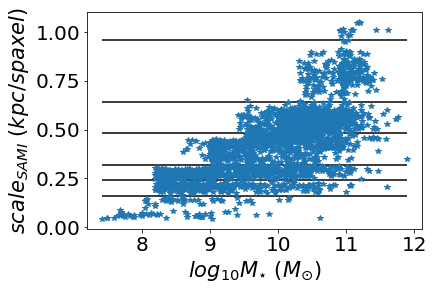

In [13]:
#The following is Extended Data Fig.1 in our paper.
scale_sami=arc2kpc*0.5
plt.plot(mstar,scale_sami,'*')
plt.xlabel('$log_{10}M_{\star}$ $(M_{\odot})$')
plt.ylabel('$scale_{SAMI}$ $(kpc/spaxel)$')
##We artificially divided the samples into seven groups of different scale regions.
plt.hlines(0.48,mstar.min(),mstar.max())
plt.hlines(0.32,mstar.min(),mstar.max())
plt.hlines(0.64,mstar.min(),mstar.max())
plt.hlines(0.16,mstar.min(),mstar.max())
plt.hlines(0.24,mstar.min(),mstar.max())
plt.hlines(0.96,mstar.min(),mstar.max())
indscag0=np.flatnonzero(scale_sami<0.16)
indscag1=np.flatnonzero((scale_sami>=0.16)*(scale_sami<0.24))
indscag2=np.flatnonzero((scale_sami>=0.24)*(scale_sami<0.32))
indscag3=np.flatnonzero((scale_sami>=0.32)*(scale_sami<0.48))
indscag4=np.flatnonzero((scale_sami>=0.48)*(scale_sami<0.64))
indscag5=np.flatnonzero((scale_sami>=0.64)*(scale_sami<0.96))
indscag6=np.flatnonzero((scale_sami>=0.96))

/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: invalid value encountered in log10
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: divide by zero encountered in log10
/home/xycrab/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:90: RuntimeWarning: invalid value encountered in log10


(-2, 0.5)

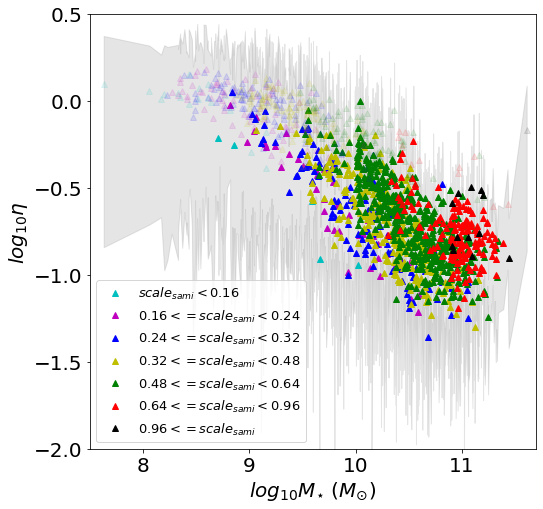

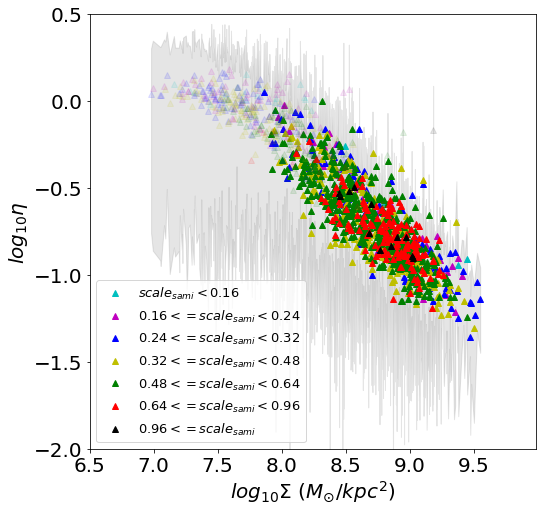

In [14]:
################
#The following is Fig.2a in our paper.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
fig,ax=plt.subplots(figsize=(8,8))
xrg=np.linspace(7,12,10000)
plt.plot(mstar[inde1t0],np.log10(chi2sumall[inde1t0]),'c^')
plt.plot(mstar[inde1t1],np.log10(chi2sumall[inde1t1]),'m^')
plt.plot(mstar[inde1t2],np.log10(chi2sumall[inde1t2]),'b^')
plt.plot(mstar[inde1t3],np.log10(chi2sumall[inde1t3]),'y^')
plt.plot(mstar[inde1t4],np.log10(chi2sumall[inde1t4]),'g^')
plt.plot(mstar[inde1t5],np.log10(chi2sumall[inde1t5]),'r^')
plt.plot(mstar[inde1t6],np.log10(chi2sumall[inde1t6]),'k^')
plt.legend(['$scale_{sami}<0.16$','$0.16<=scale_{sami}<0.24$','$0.24<=scale_{sami}<0.32$','$0.32<=scale_{sami}<0.48$','$0.48<=scale_{sami}<0.64$','$0.64<=scale_{sami}<0.96$','$0.96<=scale_{sami}$'],fontsize=13)
plt.xlabel('$log_{10}M_{\star}$ $(M_{\odot})$',fontsize=20)
plt.ylabel('$log_{10}\eta $ ',fontsize=20)
###############################
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap==0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
plt.plot(mstar[inde1t0],np.log10(chi2sumall[inde1t0]),'c^',alpha=0.1)
plt.plot(mstar[inde1t1],np.log10(chi2sumall[inde1t1]),'m^',alpha=0.1)
plt.plot(mstar[inde1t2],np.log10(chi2sumall[inde1t2]),'b^',alpha=0.1)
plt.plot(mstar[inde1t3],np.log10(chi2sumall[inde1t3]),'y^',alpha=0.1)
plt.plot(mstar[inde1t4],np.log10(chi2sumall[inde1t4]),'g^',alpha=0.1)
plt.plot(mstar[inde1t5],np.log10(chi2sumall[inde1t5]),'r^',alpha=0.1)
plt.plot(mstar[inde1t6],np.log10(chi2sumall[inde1t6]),'k^',alpha=0.1)
#########
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(mstar>=6)*(flagvescap>=0))
indsort=np.argsort(mstar[inde1t])
plt.fill_between(mstar[inde1t][indsort], np.log10(chi2nesumall)[inde1t][indsort], np.log10(2*chi2sumall-chi2nesumall)[inde1t][indsort], color='gray', alpha=0.2)
#########
extent=ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.xlim(7.5,11.7)
plt.ylim(-2,0.5)
#######
#The following is Fig.2b in our paper.
#######
#Choose galaxies with at least 50 spaxels inside Reff.
#flagvescap>0 are pure samples while flagvescap==0 are sub samples.
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap>0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
fig,ax=plt.subplots(figsize=(8,8))
xrg=np.linspace(7,12,10000)
plt.plot(surfB[inde1t0],np.log10(chi2sumall[inde1t0]),'c^')
plt.plot(surfB[inde1t1],np.log10(chi2sumall[inde1t1]),'m^')
plt.plot(surfB[inde1t2],np.log10(chi2sumall[inde1t2]),'b^')
plt.plot(surfB[inde1t3],np.log10(chi2sumall[inde1t3]),'y^')
plt.plot(surfB[inde1t4],np.log10(chi2sumall[inde1t4]),'g^')
plt.plot(surfB[inde1t5],np.log10(chi2sumall[inde1t5]),'r^')
plt.plot(surfB[inde1t6],np.log10(chi2sumall[inde1t6]),'k^')
plt.legend(['$scale_{sami}<0.16$','$0.16<=scale_{sami}<0.24$','$0.24<=scale_{sami}<0.32$','$0.32<=scale_{sami}<0.48$','$0.48<=scale_{sami}<0.64$','$0.64<=scale_{sami}<0.96$','$0.96<=scale_{sami}$'],fontsize=13)
plt.xlabel('$log_{10}\Sigma$ $(M_{\odot}/kpc^2)$',fontsize=20)
plt.ylabel('$log_{10}\eta $ ',fontsize=20)
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(flagvescap==0))
inde1t0=np.intersect1d(inde1t,indscag0)
inde1t1=np.intersect1d(inde1t,indscag1) 
inde1t2=np.intersect1d(inde1t,indscag2)
inde1t3=np.intersect1d(inde1t,indscag3)
inde1t4=np.intersect1d(inde1t,indscag4)
inde1t5=np.intersect1d(inde1t,indscag5)
inde1t6=np.intersect1d(inde1t,indscag6)
plt.plot(surfB[inde1t0],np.log10(chi2sumall[inde1t0]),'c^',alpha=0.1)
plt.plot(surfB[inde1t1],np.log10(chi2sumall[inde1t1]),'m^',alpha=0.1)
plt.plot(surfB[inde1t2],np.log10(chi2sumall[inde1t2]),'b^',alpha=0.1)
plt.plot(surfB[inde1t3],np.log10(chi2sumall[inde1t3]),'y^',alpha=0.1)
plt.plot(surfB[inde1t4],np.log10(chi2sumall[inde1t4]),'g^',alpha=0.1)
plt.plot(surfB[inde1t5],np.log10(chi2sumall[inde1t5]),'r^',alpha=0.1)
plt.plot(surfB[inde1t6],np.log10(chi2sumall[inde1t6]),'k^',alpha=0.1)
#########
inde1t=np.flatnonzero((chi2sumall>0)*(lenind2all>50)*(surfB>=6)*(flagvescap>=0))
indsort=np.argsort(surfB[inde1t])
plt.fill_between(surfB[inde1t][indsort], np.log10(chi2nesumall)[inde1t][indsort], np.log10(2*chi2sumall-chi2nesumall)[inde1t][indsort], color='gray', alpha=0.2)
#########
extent=ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
plt.xlim(6.5,9.99)
plt.ylim(-2,0.5)